<a href="https://colab.research.google.com/github/yongsa-nut/TU_CN408_GenAI_671/blob/main/Claude_Vision_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Authenthetication
- We will be using Sonnet 3.5 for this demo.

In [ ]:
!pip install -U google-cloud-aiplatform "anthropic[vertex]"

In [ ]:
!gcloud auth application-default login

In [ ]:
!gcloud auth application-default set-quota-project gen-ai-demo-3 # replace the last one with your project ID

In [ ]:
from anthropic import AnthropicVertex

project_id = "gen-ai-demo-3" # replace this with your project ID
region = "us-east5"  # Two region for Sonnet 3.5 ["us-east5", "europe-west1"]

client = AnthropicVertex(project_id=project_id, region=region)

response = client.messages.create(
    model="claude-3-5-sonnet@20240620",
    max_tokens=100,
    messages=[ { "role": "user", "content": "Hey Claude!"}]
)
print(response.content[0].text)

# Anthropic Multimodal Demo:
- Materials are from https://github.com/anthropics/anthropic-cookbook/

In [ ]:
# Cloning the github to get images for Demo
!git clone https://github.com/anthropics/anthropic-cookbook.git

In [ ]:
from IPython.display import Image
Image(filename='/content/anthropic-cookbook/images/sunset.jpeg')

### Basic Image Reading

In [ ]:
from IPython.display import Image, display
import base64

with open('/content/anthropic-cookbook/images/sunset.jpeg', "rb") as image_file:
    binary_data = image_file.read()
    base_64_encoded_data = base64.b64encode(binary_data)
    base64_string = base_64_encoded_data.decode('utf-8')

message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_string}},
            {"type": "text",
             "text": "ช่วยแต่งโครงสี่สุภาพเกี่ยวกับภาพนี้ให้หน่อย"}
        ]
    }
]

response = client.messages.create(
    model="claude-3-5-sonnet@20240620",
    max_tokens=2048,
    messages=message_list,
    temperature = 0
)
print(response.content[0].text)

In [21]:
# function for calling claude
HAIKU = "claude-3-haiku@20240307"
SONNET35 = "claude-3-5-sonnet@20240620"

def cl_generate(message_list, model = "claude-3-5-sonnet@20240620"):
  response = client.messages.create(
    model=model,
    max_tokens=2048,
    messages=message_list,
    temperature = 0
  )
  return response.content[0].text

### Passing an image through a url

- Load the image and then turn it into base64

In [ ]:
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Machu_Picchu%2C_Peru_%282018%29.jpg/2560px-Machu_Picchu%2C_Peru_%282018%29.jpg"
Image(url=IMAGE_URL)

In [ ]:
import httpx

IMAGE_DATA = base64.b64encode(httpx.get(IMAGE_URL).content).decode("utf-8")

message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64",
                        "media_type": "image/jpeg",
                        "data": IMAGE_DATA}},
            {"type": "text",
             "text": "Describe this image in two sentences."}
        ]
    }
]

print(cl_generate(message_list))

## Best practices for using vision with Claude

In [30]:
# Helper function to read image and return it as base64
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode('utf-8')
        return base64_string

In [ ]:
Image(filename='/content/anthropic-cookbook/images/best_practices/nine_dogs.jpg')

In [ ]:
# Basic instruction
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64",
                        "media_type": "image/jpeg",
                        "data": get_base64_encoded_image('/content/anthropic-cookbook/images/best_practices/nine_dogs.jpg')}},
            {"type": "text",
             "text": "How many dogs are in this picture? Only answer with the number."}
        ]
    }
]
print(cl_generate(message_list, HAIKU))

In [ ]:
# With some prompt engineering
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64",
                        "media_type": "image/jpeg",
                        "data": get_base64_encoded_image('/content/anthropic-cookbook/images/best_practices/nine_dogs.jpg')}},
            {"type": "text",
             "text": ("You have perfect vision and pay great attention to detail which makes you an expert at counting objects in images. "+
                      "How many dogs are in this picture? Before providing the answer in <answer> tags, think step by step in <thinking> tags and analyze every part of the image.")}
        ]
    }
]
print(cl_generate(message_list, HAIKU))

### Visual prompting

- Let's ask the model without any text prompt

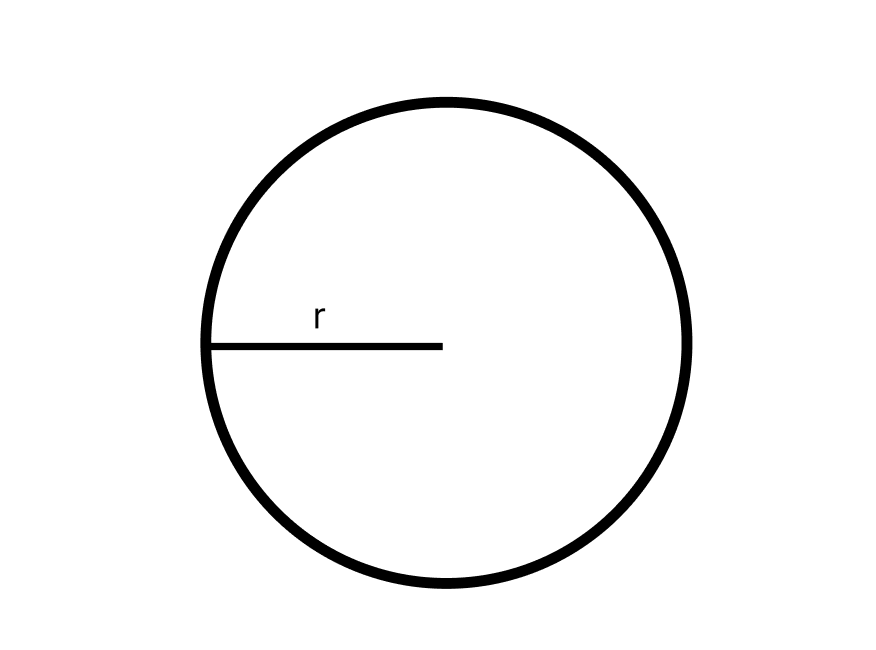

In [28]:
Image(filename='/content/anthropic-cookbook/images/best_practices/circle.png')

In [31]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64",
                        "media_type": "image/png",
                        "data": get_base64_encoded_image('/content/anthropic-cookbook/images/best_practices/circle.png')}},
        ]
    }
]

print(cl_generate(message_list))

'This image shows a simple geometric shape - a circle. Inside the circle, there is a straight line segment extending from the center to the edge of the circle. This line segment is labeled with the letter "r", which typically represents the radius of a circle in mathematics.\n\nThe radius is a key measurement in circle geometry, as it\'s the distance from the center point to any point on the circle\'s circumference. It\'s used in many formulas related to circles, such as calculating the area (πr²) or the circumference (2πr).\n\nThis diagram is a basic representation often used in mathematics, particularly in geometry lessons about circles and their properties. It\'s drawn with clean, black lines on a white background, making it clear and easy to understand.'

- The model will simply describe the image.

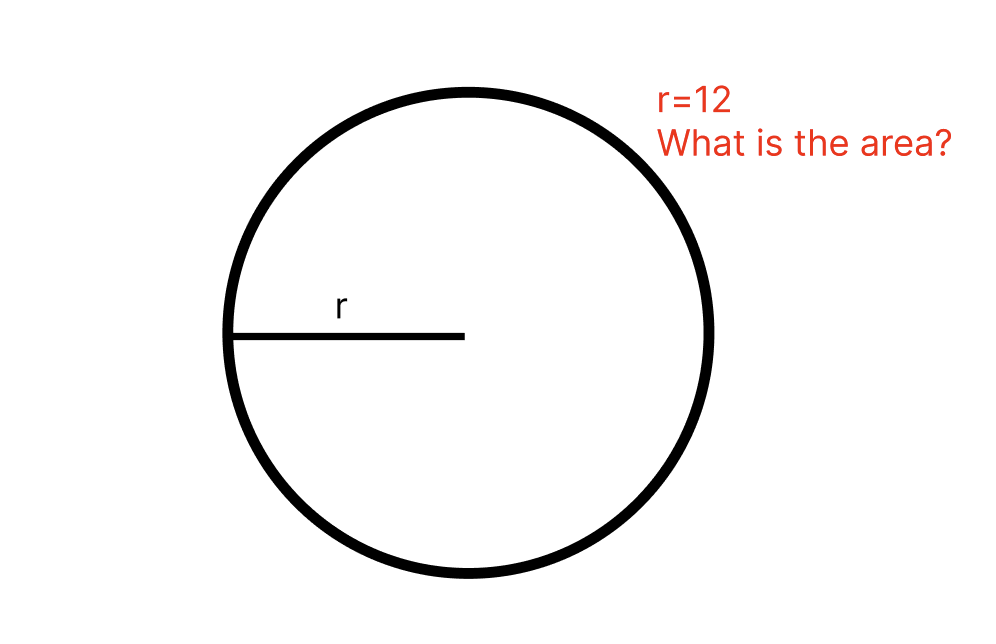

In [32]:
Image(filename='/content/anthropic-cookbook/images/best_practices/labeled_circle.png')

In [35]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source":
              {"type": "base64",
               "media_type": "image/png",
               "data": get_base64_encoded_image('/content/anthropic-cookbook/images/best_practices/labeled_circle.png')}},
        ]
    }
]

print(cl_generate(message_list))

To find the area of the circle, we use the formula:

Area = πr²

Where:
π (pi) is approximately 3.14159
r is the radius, which is given as 12

Let's plug in the values:

Area = π * 12²
    = π * 144
    = 3.14159 * 144
    ≈ 452.39 square units

Rounding to two decimal places, the area of the circle is approximately 452.39 square units.


#### Highlighting parts of the image
- We can also highlight specific parts of the image and ask questions about it.
- What's the difference between these two numbers?

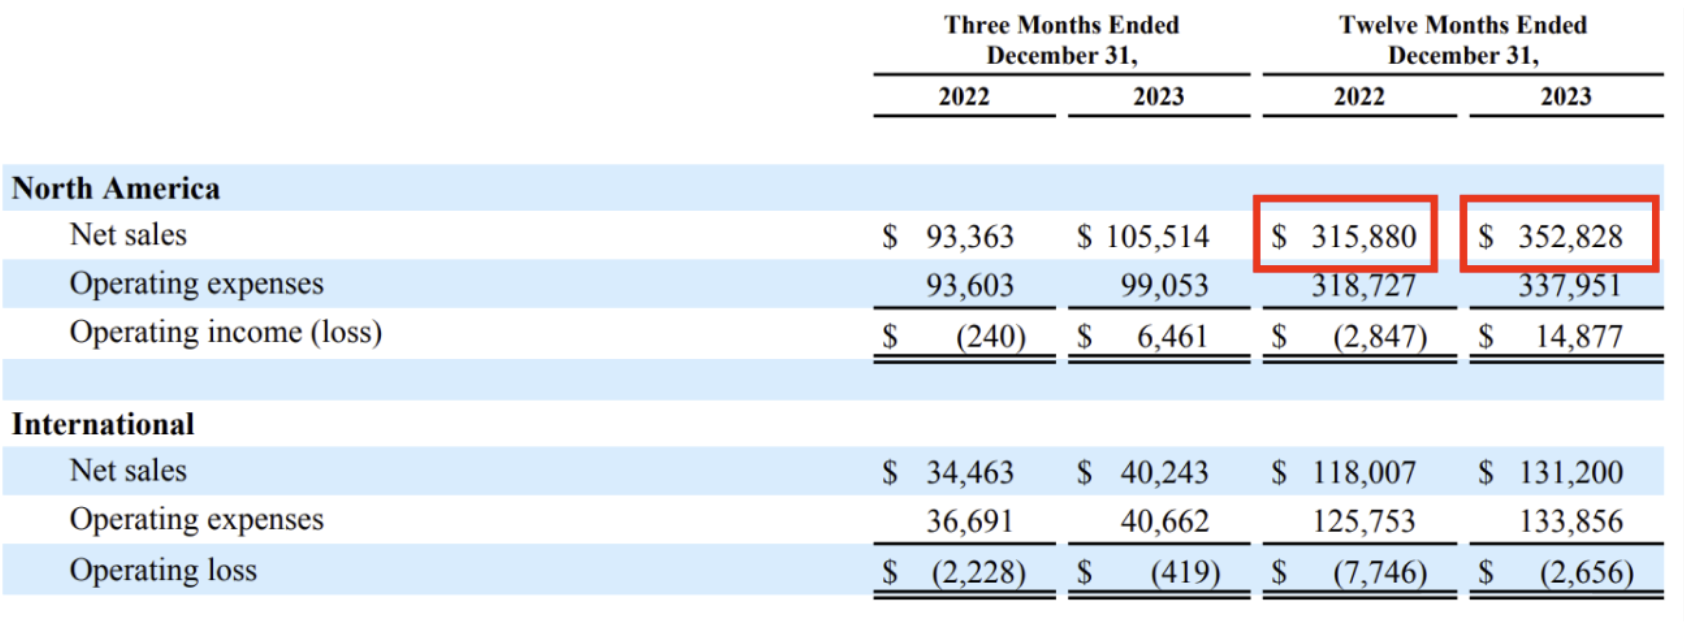

In [37]:
Image(filename='/content/anthropic-cookbook/images/best_practices/table.png')

In [39]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source":
             {"type": "base64",
              "media_type": "image/png",
              "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/table.png")}},
            {"type": "text",
             "text": "What’s the difference between these two numbers?"}
        ]
    }
]
print(cl_generate(message_list))

The difference between the two highlighted numbers is $36,948.

The number highlighted for 2022 is $315,880, which represents the net sales for North America for the twelve months ended December 31, 2022.

The number highlighted for 2023 is $352,828, which represents the net sales for North America for the twelve months ended December 31, 2023.

To calculate the difference:
$352,828 - $315,880 = $36,948

This difference indicates an increase in net sales for North America from 2022 to 2023 over the twelve-month period.


### Few-shot examples

- Adding examples to prompts still improves accuracy with visual tasks as well.

In [ ]:
Image(filename='/content/anthropic-cookbook/images/best_practices/140.png')

In [42]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image('/content/anthropic-cookbook/images/best_practices/140.png')}},
            {"type": "text",
             "text": "What speed am I going?"}
        ]
    }
]
print(cl_generate(message_list))

According to the speedometer in the image, the vehicle is traveling at 110.582 kilometers per hour.


In [ ]:
print(cl_generate(message_list, HAIKU))

- Let's try giving Haiku some examples.

In [ ]:
Image("/content/anthropic-cookbook/images/best_practices/70.png")

In [45]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/70.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"type": "text", "text": "You are going 70 miles per hour."}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png",
                                         "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/100.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"type": "text", "text": "You are going 100 miles per hour."}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png",
                                         "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/140.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    }
]
print(cl_generate(message_list))

Based on the speedometer shown in the image, you are going approximately 140 miles per hour. The yellow needle is pointing very close to the 140 mph mark on the outer ring of the speedometer. This is an extremely high and dangerous speed for most road conditions. I would strongly advise reducing your speed immediately for safety reasons if this is an actual current reading.


In [ ]:
print(cl_generate(message_list, HAIKU))

### Multiple images as input
- Claude can accept and take in to account multiple images.

In [ ]:
Image(filename='/content/anthropic-cookbook/images/best_practices/receipt1.png')

In [ ]:
Image(filename='/content/anthropic-cookbook/images/best_practices/receipt2.png')

In [48]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
              "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/receipt1.png")}},
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
             "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/receipt2.png")}},
            {"type": "text",
             "text": "Output the name of the restaurant and the total."}
        ]
    }
]

print(cl_generate(message_list))

The name of the restaurant is The Breakfast Club, and the total on the receipt is $78.86.


### Object identification from examples

- With image input, you can pass in other images to the prompt and Claude will use that information to answer questions.

- Suppose we were trying to identify the type of pant in an image.

In [ ]:
Image(filename='/content/anthropic-cookbook/images/best_practices/officer_example.png')

- We can provide Claude some examples of different types of pants in the prompt.

In [ ]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/wrinkle.png")}},
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/officer.png")}},
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/chinos.png")}},
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/best_practices/officer_example.png")}},
            {"type": "text",
             "text": "These pants are (in order) WRINKLE-RESISTANT DRESS PANT, ITALIAN MELTON OFFICER PANT, SLIM RAPID MOVEMENT CHINO. What pant is shown in the last image?"}
        ]
    }
]
print(cl_generate(message_list))

## Transcribe documents with Claude

### Transcribing typed text
- The advantage of using Claude over traditional OCR systems is that **you can specify exactly what you want to transcribe**.

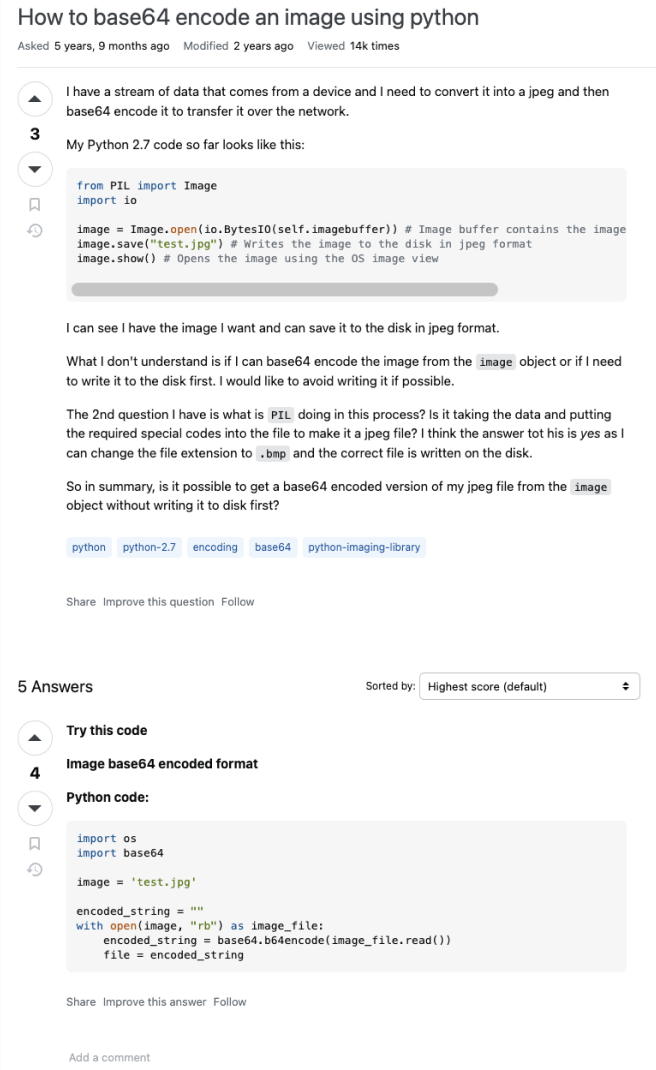

In [52]:
Image(filename='/content/anthropic-cookbook/images/transcribe/stack_overflow.png')

- Let's transcribe just the code in the answer.

In [53]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/transcribe/stack_overflow.png")}},
            {"type": "text",
             "text": "Transcribe the code in the answer. Only output the code."}
        ]
    }
]
print(cl_generate(message_list))

Here's the transcription of the code in the answer:

```python
import os
import base64

image = 'test.jpg'

encoded_string = ""
with open(image, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
file = encoded_string
```


### Transcribing handwritten text
- Claude can transcribe handwritten texts quite well.

In [ ]:
Image(filename='/content/anthropic-cookbook/images/transcribe/school_notes.png')

In [ ]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/transcribe/school_notes.png")}},
            {"type": "text",
             "text": "Transcribe this text. Only output the text and nothing else."}
        ]
    }
]
print(cl_generate(message_list))

### Transcribing forms

In [ ]:
Image(filename='/content/anthropic-cookbook/images/transcribe/vehicle_form.jpg')

In [55]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/jpeg",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/transcribe/vehicle_form.jpg")}},
            {"type": "text",
             "text": "Transcribe this form exactly."}
        ]
    }
]
print(cl_generate(message_list))

VEHICLE INCIDENT REPORT FORM

Use this form to report accidents, injuries, medical situations, criminal activities, traffic
incidents, or student behavior incidents. If possible, a report should be completed within
24 hours of the event.

Date of Report: 02/29, 2024

PERSON INVOLVED

Full Name: John Doe    Address: 123 Main St

Identification: ☑ Driver's License No. 474921    □ Passport No. __________
□ Other: _________________________

Phone: (678)999-8212 E-Mail: john@gmail.com

THE INCIDENT

Date of Incident: 02/29/2024,    Time: 9:01 ☑ AM □ PM

Location: Corner of 2nd and 3rd

Describe the Incident: Red car t-boned blue car

INJURIES

Was anyone injured? □ Yes ☑ No

If yes, describe the injuries: _________________________________________________
________________________________________________________________________
________________________________________________________________________

WITNESSES

Were there witnesses to the incident? □ Yes ☑ No

If yes, enter the witnesses' nam

### Complicated document QA

In [ ]:
Image(filename='/content/anthropic-cookbook/images/transcribe/page.jpeg')

In [ ]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/jpeg",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/transcribe/page.jpeg")}},
            {"type": "text",
             "text": "Which is the most critical issue for live rep support?"}
        ]
    }
]
print(cl_generate(message_list))

### Unstructured information -> JSON

In [ ]:
Image(filename='/content/anthropic-cookbook/images/transcribe/org_chart.jpeg')

In [ ]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/jpeg",
                        "data": get_base64_encoded_image("/content/anthropic-cookbook/images/transcribe/org_chart.jpeg")}},
            {"type": "text",
             "text": "Turn this org chart into JSON indicating who reports to who. Only output the JSON and nothing else."}
        ]
    }
]

print(cl_generate(message_list))

## Working with Charts, Graphs, and Slide Decks

- Claude is highly capable of working with charts, graphs, and broader slide decks

### Charts and Graphs

In [ ]:
Image(filename='/content/anthropic-cookbook/images/reading_charts_graphs/cvna_2021_annual_report_image.png')

In [63]:
cvna_2021_report = get_base64_encoded_image('/content/anthropic-cookbook/images/reading_charts_graphs/cvna_2021_annual_report_image.png')
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": cvna_2021_report}},
            {"type": "text",
             "text": "What's in this image? Answer in a single sentence."}
        ]
    }
]
print(cl_generate(message_list))

This image shows four charts displaying Carvana's growth from 2014 to 2021 in retail units sold, total revenue, total markets at year end, and car vending machines, as presented in their 2021 annual report.


- Now let's ask it some more useful questions.

In [64]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image",
             "source": {"type": "base64", "media_type": "image/png",
                        "data": cvna_2021_report}},
            {"type": "text",
             "text": "What was CVNA revenue in 2020?"}
        ]
    }
]
print(cl_generate(message_list))

According to the "Total Revenue ($M)" chart in the image, Carvana's revenue in 2020 was $5,587 million.


### Tips on working with charts

- Sometimes Claude's arithmetic capabilities get in the way. Consider **providing Claude with a calculator tool** (next week!) to ensure it doesn't make these types of mistakes.

- With super complicated charts and graphs, we can **ask Claude to "First describe every data point you see in the image"** as a way to elicit similar improvements to what we seen in traditional Chain of Thought.

- Claude occasionally struggles with charts that depend on lots of colors to convey information, such as grouped bar charts with many groups. **Asking Claude to first identify the colors in your graph** using HEX codes can boost its accuracy.

### Slide Decks

- We can make claude work with slide too.
- The best way to get a typical slide deck into claude is to download it as a PDF and then convert each pdf page to an image. Here's how you can accomplish this.

In [ ]:
!pip install PyMuPDF

In [66]:
from PIL import Image
import io
import fitz

# Define the function to convert a pdf slide deck to a list of images. Note that we need to ensure we resize images to keep them within Claude's size limits.
def pdf_to_base64_pngs(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Save the PNG image
        output_path = f"/content/anthropic-cookbook/images/reading_charts_graphs/slides/page_{page_num+1}.png"
        pix.save(output_path)

    # Convert the PNG images to base64 encoded strings
    images = [Image.open(f"/content/anthropic-cookbook/images/reading_charts_graphs/slides/page_{page_num+1}.png") for page_num in range(doc.page_count)]
    # Close the PDF document
    doc.close()

    base64_encoded_pngs = []

    for image in images:
        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    return base64_encoded_pngs

# Call the function on our q4 2023 Twilio Earnings presentation
pdf_path = '/content/anthropic-cookbook/images/reading_charts_graphs/twilio_q4_2023.pdf' # This is the path to our slide deck.
encoded_pngs = pdf_to_base64_pngs(pdf_path)

In [ ]:
Image(data=base64.b64decode(encoded_pngs[1]))

In [72]:
# Now let's pass the first 20 of these images (in order) to Claude at once and ask it a question about the deck. Why 20? Currently, the Anthropic API only allows you to pass in a maximum of 20 images. While this number will likely increase over time, we have some helpful tips for how to manage it later in this recipe.
content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs[:20]]
question = "What was Twilio y/y revenue growth for fiscal year 2023?"
content.append({"type": "text", "text": question})

messages = [
    {
        "role": 'user',
        "content": content
    }
]

print(cl_generate(messages))

According to the "Total Company Results Highlights" table in the image, Twilio's year-over-year (Y/Y) revenue growth for fiscal year 2023 was 9%.


### Asking Claude to sequentially narrate the slide

In [73]:
# Define two functions that allow us to craft prompts for narrating our slide deck. We would adjut these prompts based on the nature of the deck, but keep the structure largely the same.
def build_previous_slides_prompt(previous_slide_narratives):
    prompt = '\n'.join([f"<slide_narration id={index+1}>\n{narrative}\n</slide_narration>" for index, narrative in enumerate(previous_slide_narratives)])
    return prompt

def build_slides_narration_prompt(previous_slide_narratives):
    if len(previous_slide_narratives) == 0:
        prompt = """You are the Twilio CFO, narrating your Q4 2023 earnings presentation.

You are currently on slide 1, shown in the image.
Please narrate this page from Twilio's Q4 2023 Earnings Presentation as if you were the presenter. Do not talk about any things, especially acronyms, if you are not exactly sure you know what they mean. Do not discuss anything not explicitly seen on this slide as there are more slides to narrate later that will likely cover that material.
Do not leave any details un-narrated as some of your viewers are vision-impaired, so if you don't narrate every number they won't know the number.

Put your narration in <narration> tags."""

    else:
        prompt = f"""You are the Twilio CFO, narrating your Q4 2023 earnings presentation. So far, here is your narration from previous slides:
<previous_slide_narrations>
{build_previous_slides_prompt(previous_slide_narratives)}
</previous_slide_narrations>

You are currently on slide {len(previous_slide_narratives)+1}, shown in the image.
Please narrate this page from Twilio's Q4 2023 Earnings Presentation as if you were the presenter, accounting for what you have already said on previous slides. Do not talk about any things, especially acronyms, if you are not exactly sure you know what they mean. Do not discuss anything not explicitly seen on this slide as there are more slides to narrate later that will likely cover that material.
Do not leave any details un-narrated as some of your viewers are vision-impaired, so if you don't narrate every number they won't know the number.

Use excruciating detail.

Put your narration in <narration> tags."""

    return prompt

In [ ]:
# Now we use our functions to narrate the entire deck. Note that this may take a few minutes to run (often up to 10).
import re
from tqdm import tqdm

previous_slide_narratives = []
for i, encoded_png in tqdm(enumerate(encoded_pngs)):
    messages = [
        {
            "role": 'user',
            "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}},
            {"type": "text", "text": build_slides_narration_prompt(previous_slide_narratives)}
        ]
        }
    ]
    completion = cl_generate(messages, HAIKU) #If you run this, you will likely out of resources

    pattern = r"<narration>(.*?)</narration>"
    match = re.search(pattern, completion.strip(), re.DOTALL)
    if match:
        narration = match.group(1)
    else:
        raise ValueError("No narration available.")

    previous_slide_narratives.append(narration)
    # If you want to see the narration we produced, uncomment the below line
    print(narration)

slide_narration = build_previous_slides_prompt(previous_slide_narratives)

Finally, let's ask a few questions of our narration-only setup!



In [ ]:
questions = [
    "What percentage of q4 total revenue was the Segment business line?",
    "Has the rate of growth of quarterly revenue been increasing or decreasing? Give just an answer.",
    "What was acquisition revenue for the year ended december 31, 2023 (including negative revenues)?"
]

for index, question in enumerate(questions):
    prompt = f"""You are an expert financial analyst analyzing a transcript of Twilio's earnings call.
Here is the transcript:
<transcript>
{slide_narration}
</transcript>

Please answer the following question:
<question>
{question}
</question>"""
    messages = [
        {

            "role": 'user',
            "content": [
                {"type": "text", "text": prompt}
            ]
        }
    ]

    print(f"\n----------Question {index+1}----------")
    print(get_completion(messages))